In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import viz_tools, visualisations, tidetools

%matplotlib inline

In [2]:
ds ={}
datestr = '20160728_20160824'
lo = '/ocean/nsoontie/MEOPAR/SalishSea/results/live_ocean/live_ocean_test/restart2/'
base = '/ocean/nsoontie/MEOPAR/SalishSea/results/live_ocean/base/restart2/'
fname = '{}SalishSea_1d_{}_grid_T.nc'.format(lo, datestr)

ds['lo'] = xr.open_dataset(fname)
fname= '{}SalishSea_1d_{}_grid_T.nc'.format(base, datestr)
ds['base'] = xr.open_dataset(fname)

In [3]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid)

In [4]:
def compare_thalwegs(ds, runs, t, varname, units, bathy, lons, lats, mesh_mask, clevels, cmap='hsv'):
    fig,axs = plt.subplots(3,1,figsize=(15,13))
    for ax, key in zip(axs[0:2], runs):
        cbar = visualisations.contour_thalweg(ax, ds[key][varname].isel(time_counter=t).values[:],
                                              bathy, lons, lats, mesh_mask, 'gdept', clevels=clevels,
                                              cmap=cmap)
        ax.set_ylim([420,0])
        ax.set_title('{}: {}'.format(key, ds[key].time_counter.isel(time_counter=t).values))
        cbar.set_label('{} {}'.format(varname, units))
    ax=axs[-1]
    diff = ds[runs[1]][varname].isel(time_counter=t).values[:] -\
           ds[runs[0]][varname].isel(time_counter=t).values[:]
    cbar = visualisations.contour_thalweg(ax, diff,
                                          bathy, lons, lats, mesh_mask, 'gdept', clevels=np.arange(-1,1.1,.1),
                                          cmap='bwr')
    cbar.set_label('{} {}'.format(varname, units))
    ax.set_title('difference: {} - {}'.format(runs[1], runs[0]))
    ax.set_ylim([420,0])
    return fig

# Thalwegs

## 28 days

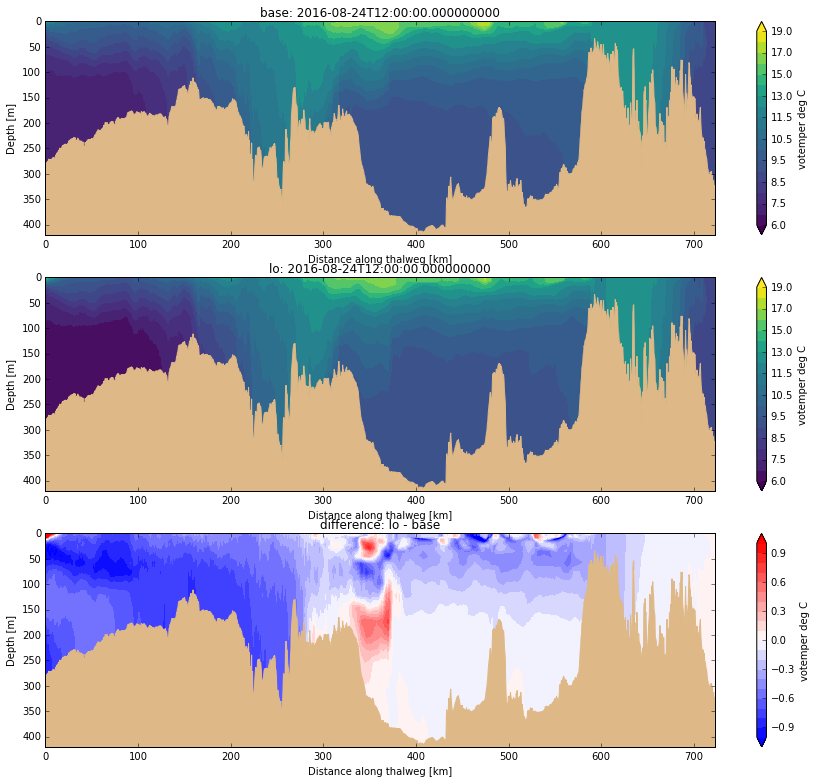

In [5]:
runs=['base','lo']
t=-1
clevels=[6, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12,
         13, 14, 15, 16, 17, 18, 19]
fig=compare_thalwegs(ds, runs, t, 'votemper', 'deg C',  bathy, lons, lats, mesh_mask, 
                 clevels=clevels, cmap='viridis')

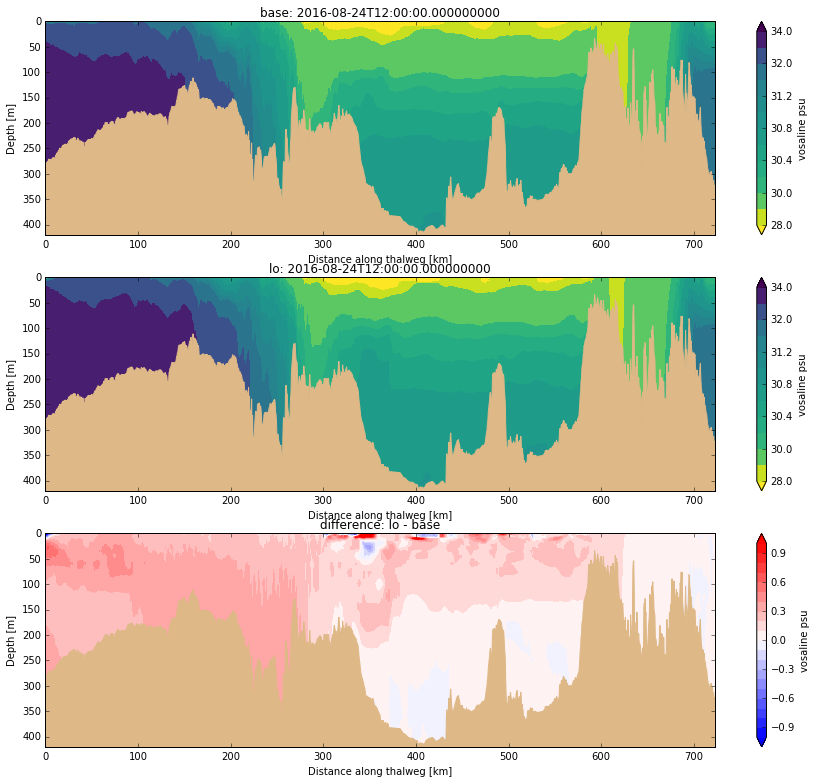

In [6]:
clevels = [ 28, 29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4, 32, 33, 34
          ]
fig=compare_thalwegs(ds, runs, t, 'vosaline', 'psu',  bathy, lons, lats, mesh_mask, 
                 clevels=clevels, cmap='viridis_r')

## Neap tide

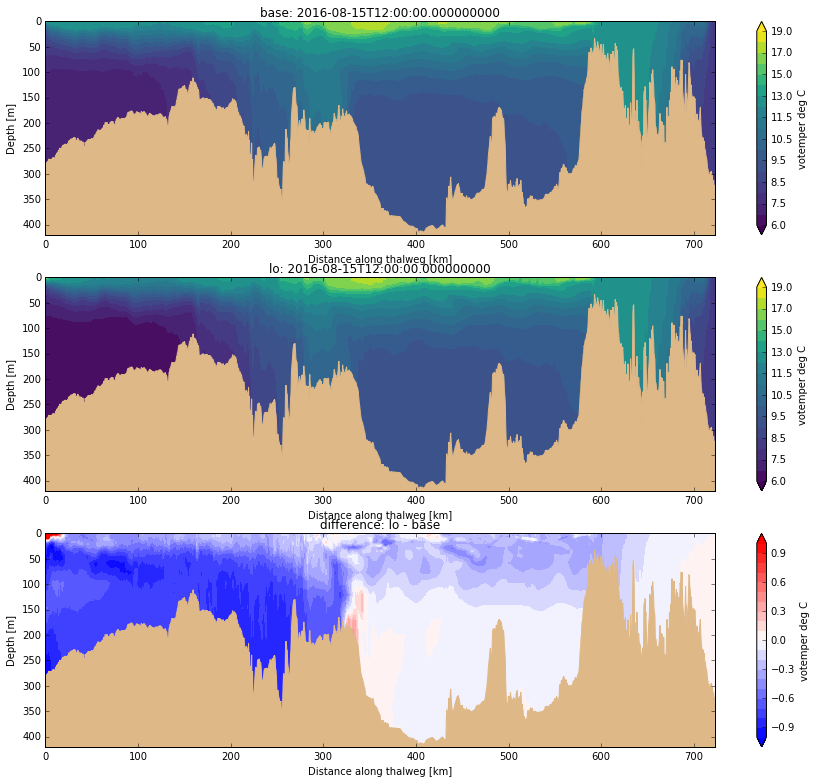

In [7]:
t=18
clevels=[6, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12,
         13, 14, 15, 16, 17, 18, 19]
fig=compare_thalwegs(ds, runs, t, 'votemper', 'deg C',  bathy, lons, lats, mesh_mask, 
                 clevels=clevels, cmap='viridis')

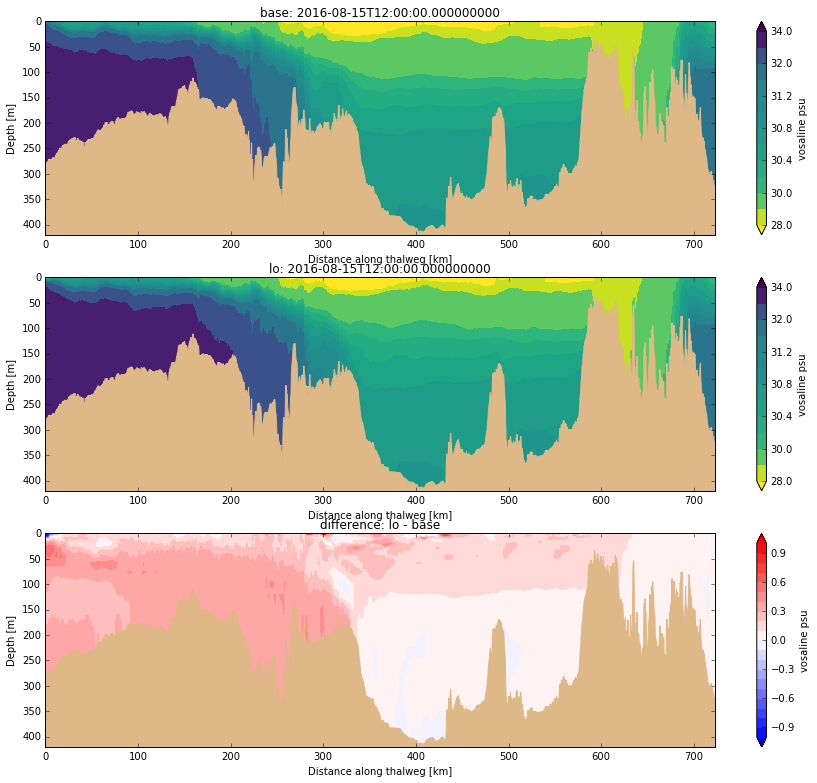

In [8]:
clevels = [ 28, 29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4, 32, 33, 34
          ]
fig=compare_thalwegs(ds, runs, t, 'vosaline', 'psu',  bathy, lons, lats, mesh_mask, 
                 clevels=clevels, cmap='viridis_r')

# Surface

In [9]:
def compare_surface(ds, runs, t, varname, units, clevels, mesh_mask, diff_lims = np.arange(-1,1.1,.1),
                    cmap='hsv'):
    fig,axs = plt.subplots(1,3,figsize=(15,8))
    for ax, key in zip(axs[0:2], runs):
        tmask = mesh_mask.variables['tmask'][0,0,:,:]
        var = np.ma.array(ds[key][varname].isel(time_counter=t, deptht=0).values[:], mask=1-tmask)
        mesh = ax.contourf(var,clevels,cmap=cmap)
        cbar=plt.colorbar(mesh,ax=ax)             
        ax.set_title('{}: {}'.format(key, ds[key].time_counter.isel(time_counter=t).values))
        cbar.set_label('{} {}'.format(varname, units))
    ax=axs[-1]
    diff = ds[runs[1]][varname].isel(time_counter=t,deptht=0).values[:] -\
           ds[runs[0]][varname].isel(time_counter=t,deptht=0).values[:]
    diff = np.ma.array(diff,mask=1-tmask)
    mesh = ax.contourf(diff,diff_lims,cmap='bwr')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('{} {}'.format(varname, units))
    ax.set_title('difference: {} - {}'.format(runs[1], runs[0]))
    return fig

## 28 days

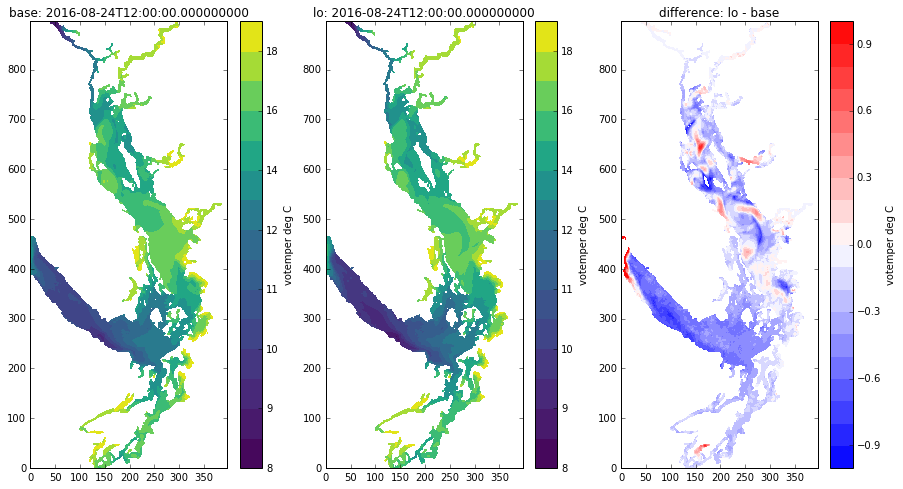

In [10]:
clevels=[ 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12,
         13, 14, 15, 16, 17, 18, 19]
t=-1
fig = compare_surface(ds, runs, t, 'votemper', 'deg C', clevels, mesh_mask, cmap='viridis')

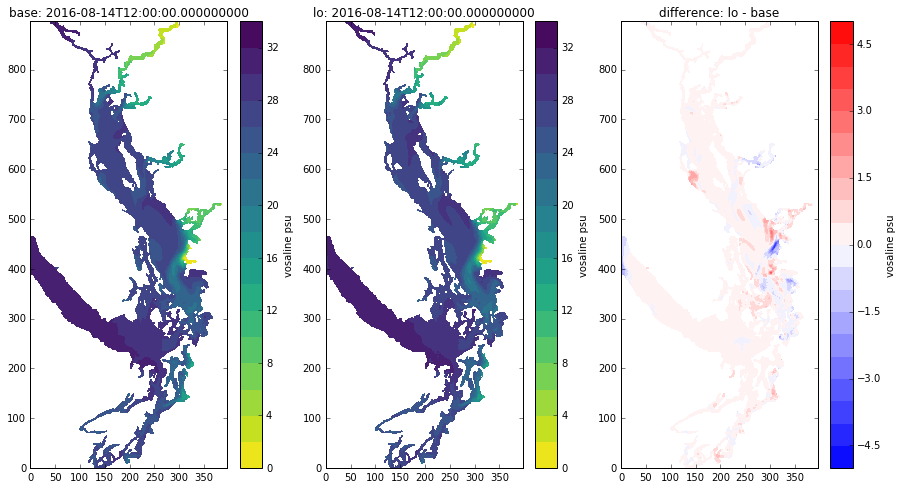

In [11]:
clevels= np.arange(0,36,2)
t=17
diff_lims = np.arange(-5,5.5,.5)
fig = compare_surface(ds, runs, t, 'vosaline', 'psu', clevels, mesh_mask, diff_lims = diff_lims,
                      cmap='viridis_r')

# Transect through JDF

In [12]:
def compare_transect(ds,runs, t, i, varname, units, mesh_mask, gridB, ylims, diff_lims, clevels, cmap='hsv' ):
    fig,axs = plt.subplots(1,3,figsize=(15,4))
    for ax, key in zip(axs[0:2], runs):
        tmask = mesh_mask.variables['tmask'][0,:,:,i]
        gdept = mesh_mask.variables['gdept'][0,:,:,i]
        var = np.ma.array(ds[key][varname].isel(time_counter=t, x=i).values[:], mask=1-tmask)
        yy, _ = np.meshgrid(np.arange(var.shape[-1]), gdept[:,0])
        mesh = ax.contourf(yy, gdept, var,clevels,cmap=cmap)
        cbar=plt.colorbar(mesh,ax=ax)             
        ax.set_title('{}: {}'.format(key, ds[key].time_counter.isel(time_counter=t).values))
        cbar.set_label('{} {}'.format(varname, units))
    ax=axs[-1]
    diff = ds[runs[1]][varname].isel(time_counter=t,x=i).values[:] -\
           ds[runs[0]][varname].isel(time_counter=t,x=i).values[:]
    diff = np.ma.array(diff,mask=1-tmask)
    mesh = ax.contourf(yy,gdept,diff,diff_lims,cmap='bwr')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('{} {}'.format(varname, units))
    ax.set_title('difference: {} - {}'.format(runs[1], runs[0]))
    bathy = gridB.variables['Bathymetry'][:]
    for ax in axs:
        ax.set_xlim(ylims)
        ax.set_ylim([200,0])
        ax.set_xlabel('j index')
        ax.set_ylabel('Depth [m]')
        ax.plot(yy[0,:], bathy[:,i], 'k')
    return fig

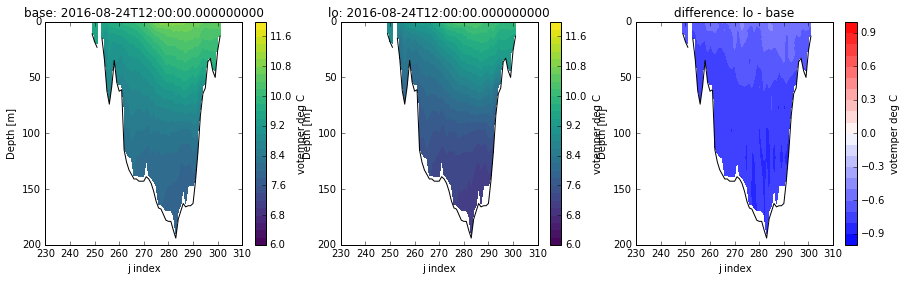

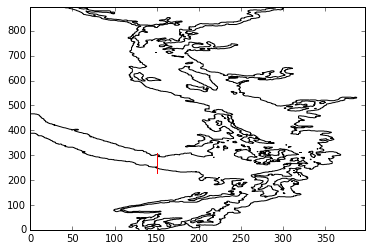

In [13]:
i=150
t=-1
diff_lims = np.arange(-1,1.1,.1)
clevels=np.arange(6,12.2,.2)
ylims = [230,310]
fig=compare_transect(ds,runs, t, i, 'votemper', 'deg C', mesh_mask, grid, ylims, diff_lims, 
                 clevels, cmap='viridis' )
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid)
ax.plot([i,i], ylims, 'r')

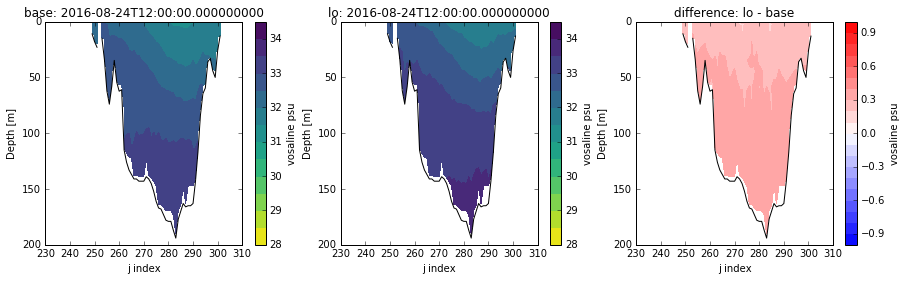

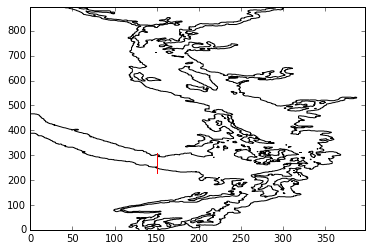

In [14]:
diff_lims = np.arange(-1,1.1,.1)
clevels=np.arange(28,35,.5)
fig=compare_transect(ds,runs, t, i, 'vosaline', 'psu', mesh_mask, grid, ylims, diff_lims, 
                 clevels, cmap='viridis_r' )
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid)
ax.plot([i,i], ylims, 'r')

# Transport
sum(u*dy*dz) averaged over 28 days

In [15]:
du={}
fname = '{}SalishSea_1d_{}_grid_U.nc'.format(lo, datestr)
du['lo'] = xr.open_dataset(fname)
fname= '{}SalishSea_1d_{}_grid_U.nc'.format(base, datestr)
du['base'] = xr.open_dataset(fname)

In [16]:
def compare_transport(du, i,js, runs, mesh_mask):
    jslice=slice(js[0],js[1])
    e3u = mesh_mask.variables['e3u'][:,:,js[0]:js[1],i]
    e2u = mesh_mask.variables['e2u'][:,js[0]:js[1],i]
    e2u = np.expand_dims(e2u,axis=0)
    umask = mesh_mask.variables['umask'][:,:,js[0]:js[1],i]
    area = e2u*e3u
    for run, col in zip(runs, ['b','g']):
        transport = np.sum(np.sum(du[run]['vozocrtx'].isel(x=i,y=jslice)*area*umask, axis=-1), axis=-1)
        print('Mean transport (m^3/s): ', run , np.mean(transport).values)

Mean transport (m^3/s):  base -7644.496595348335
Mean transport (m^3/s):  lo -7601.2731272124165


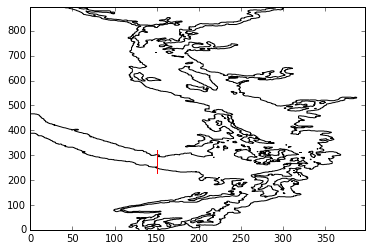

In [17]:
js = [230,320]
i=150
compare_transport(du, i, js, runs, mesh_mask)
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid)
ax.plot([i,i], js, 'r')